In [7]:
import cv2

import os
import sys
import numpy as np
import aruco
from matplotlib import pyplot as plt
sys.path.append('..')
from utils import * # Please note that many of the function used in the notebook are located in the utils

In [8]:
# Constants declaration

# Camera configuration
camera_config = "../arucoConfig/baumer12mm1mf.yml"
camparam = aruco.CameraParameters()
camparam.readFromXMLFile(camera_config)

# Configuration of the boxes and creation of marker maps
lower_box_config = "../arucoConfig/block1(lowest).yml"
higher_box_config = "../arucoConfig/block2(highest).yml"
mmap_lowest = aruco.MarkerMap(lower_box_config)
mmap_highest = aruco.MarkerMap(higher_box_config)

# Example videos
video_example1 = "../Data/baumer_video0043.avi"
video_example2 = "../Data/baumer_video0050.avi"

# Center of the block
lower_box_center_location = "../arucoConfig/AxisCentreBlock1.csv"
upper_box_center_location = "../arucoConfig/AxisCentreBlock2.csv"

lower_box_loc = np.fromstring(open(lower_box_center_location).read(), sep=' ')[-3:]/1000
upper_box_loc = np.fromstring(open(upper_box_center_location).read(), sep=' ')[-3:]/1000

In [9]:
sm_l = np.fromstring(open(lower_box_center_location).read(), sep=' ')[:3]
sm_u = np.fromstring(open(upper_box_center_location).read(), sep=' ')[:3]

## How markers are located

detected ids: 7, 15, 19, 21, 24


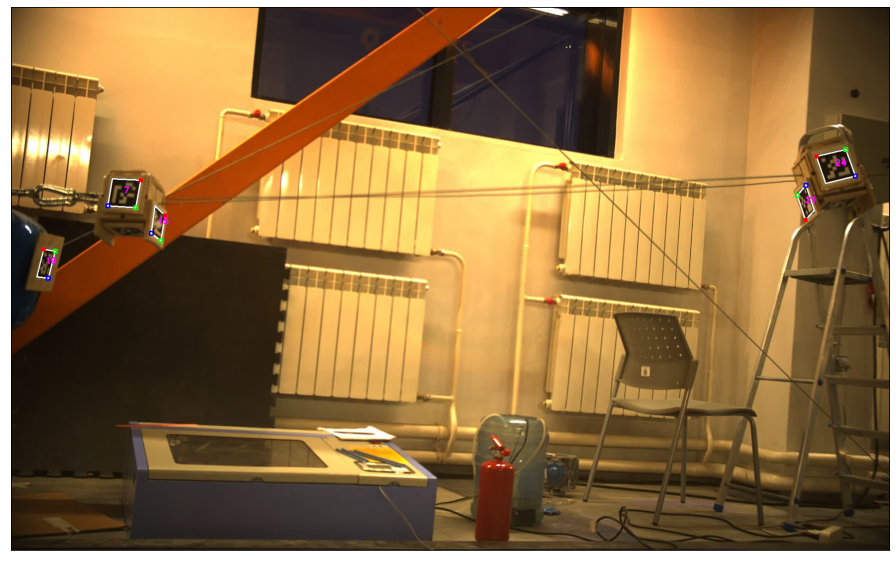

In [10]:
# Open video with cv2
cap = cv2.VideoCapture(video_example1)
ret, frame = cap.read() # Take first frame

# Init detector and get markers
detector = aruco.MarkerDetector()
markers = detector.detect(frame)
print("detected ids: {}".format(", ".join(str(m.id) for m in markers)))

for marker in markers:
    marker.draw(frame, np.array([255, 255, 255]), 2)
    aruco.CvDrawingUtils.draw3dAxis(frame, camparam, marker.Rvec, marker.Tvec, .1)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

## How the markermap location looks like

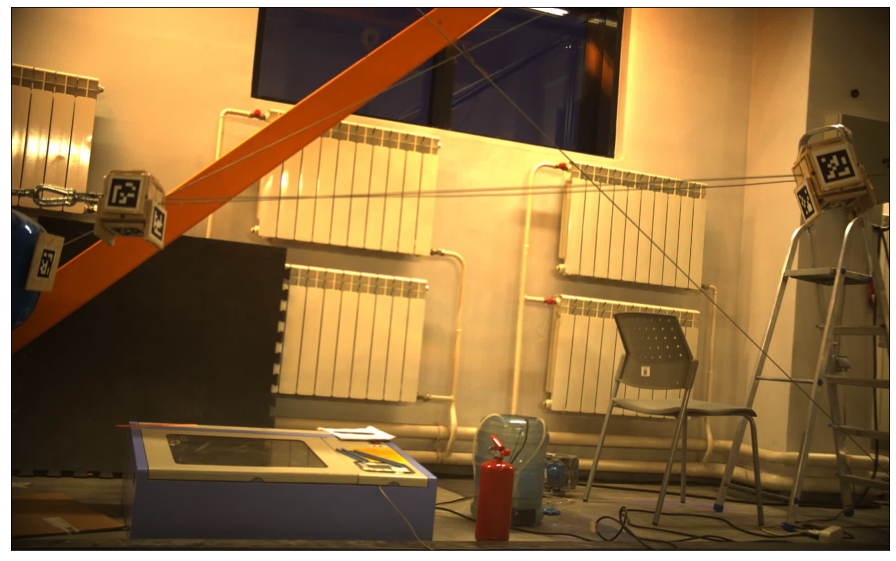

In [11]:
# Take first picture from the video
cap = cv2.VideoCapture(video_example1)
ret, frame = cap.read()

# Init detector and marker map pose trackers
detector, mmap_low_p, mmap_high_p = get_new_MM_posers(camparam, mmap_lowest, mmap_highest)

markers = detector.detect(frame)


mmap_low_p.estimatePose(markers), mmap_high_p.estimatePose(markers)

# if mmap_low_p.isValid():
#     aruco.CvDrawingUtils.draw3dAxis(frame, camparam, mmap_low_p.getRvec(), tune_tvector(mmap_low_p, True), .1)
# if mmap_high_p.isValid():
#     aruco.CvDrawingUtils.draw3dAxis(frame, camparam, mmap_high_p.getRvec(), tune_tvector(mmap_high_p, False), .1)


plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
 cv2.Rodrigues(sm_u)[0],  cv2.Rodrigues(sm_l)[0]

(array([[ 0.54039104,  0.01114342, -0.84134021],
        [-0.02391304,  0.9997118 , -0.00211827],
        [ 0.84107413,  0.02126369,  0.54050177]]),
 array([[ 0.54156023,  0.01195214,  0.84057698],
        [-0.05993663,  0.99790328,  0.02442634],
        [-0.83852258, -0.06360969,  0.5411411 ]]))

In [13]:
print(get_center_box_pos(mmap_low_p, lower_box_loc))
print(get_center_box_pos(mmap_high_p, upper_box_loc))

[-0.68556462 -0.14672433  1.96671816]
[ 0.72879565 -0.20366068  1.9524924 ]


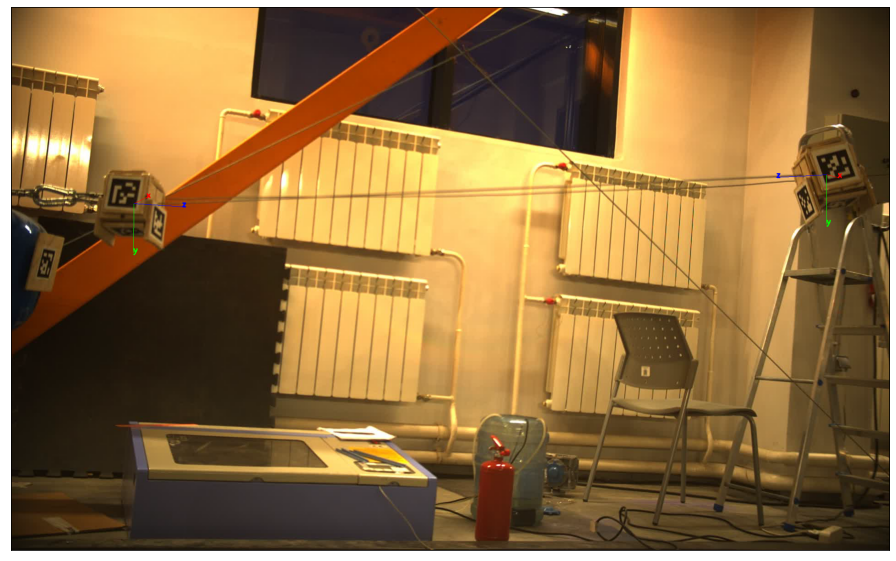

In [14]:
aruco.CvDrawingUtils.draw3dAxis(frame, camparam, cv2.Rodrigues(sm_l)[0], np.array([get_center_box_pos(mmap_low_p, lower_box_loc)]), .1)
aruco.CvDrawingUtils.draw3dAxis(frame, camparam, cv2.Rodrigues(sm_u)[0], np.array([get_center_box_pos(mmap_high_p, upper_box_loc)]), .1)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
cap = cv2.VideoCapture(video_example2)
ret, frame = cap.read()

# Try to find a picture with at least 4 markers, marker map would fail otherwise
while ret:
    detector = aruco.MarkerDetector()
    markers = detector.detect(frame)
    if len(markers) == 4:
        break
    ret, frame = cap.read()

## Check how marker map look in another setting

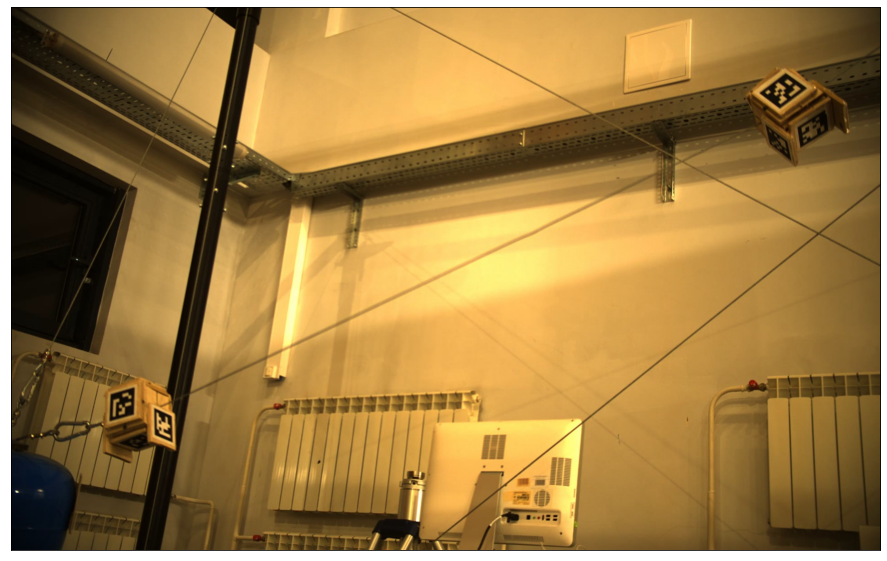

In [17]:
frame_copy = frame.copy()
detector, mmap_low_p, mmap_high_p = get_new_MM_posers(camparam, mmap_lowest, mmap_highest)

markers = detector.detect(frame)
mmap_low_p.estimatePose(markers), mmap_high_p.estimatePose(markers)

#if mmap_low_p.isValid():
#    aruco.CvDrawingUtils.draw3dAxis(frame_copy, camparam, mmap_low_p.getRvec(), tune_tvector(mmap_low_p, True), .1)
#if mmap_high_p.isValid():
#    aruco.CvDrawingUtils.draw3dAxis(frame_copy, camparam, mmap_high_p.getRvec(), tune_tvector(mmap_high_p, False), .1)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
def get_center_box_pos(mmap, center_location):
    rt_matrix = mmap.getRTMatrix()[:-1, :] # Q|t matrix 
    threeD_loc = rt_matrix @ np.append(center_location, 1) # [Q|t] * homogeneous_center_box
    return threeD_loc

In [11]:
def get_2d_from_3d(vector_3d, camera_matrix):
    d2 = camera_matrix @ vector_3d # Camera matrix * vector_3d
    return int(d2[0]/d2[-1]), int(d2[1]/d2[-1])

In [12]:
distortion = np.array([0, 0, 0, 0, 0], dtype=np.float32)
point_3d = upper_box_loc
point = cv2.projectPoints(np.array([[point_3d]]), mmap_high_p.getRvec(), mmap_high_p.getTvec(), camparam.CameraMatrix, distortion)
x, y = tuple(point[0][0][0])
int(x), int(y)

(1710, 229)

In [14]:
## Problem!
# [Q|T] Matrix
rt_matrix = mmap_low_p.getRTMatrix()[:-1, :]
print('[Q|T] matrix')
print(rt_matrix)

print ('Check that it is correct!')
rotation_matrix = np.zeros(shape=(3,3))
print('Q')
print(cv2.Rodrigues(mmap_low_p.getRvec(), rotation_matrix)[0])
print('T')
print(mmap_low_p.getTvec())

# homogeneous coordinate system of the box
print('Lower box location')
low = np.append(lower_box_loc, 1)
print(low)
print('3D location')
vector_3d = rt_matrix @ low
print(vector_3d)
print('2D location is thus Camera * 3D Location')

print('Camera Matrix')
print(camparam.CameraMatrix)
vector_2d = camparam.CameraMatrix @ vector_3d
vector_2d = vector_2d/vector_2d[-1]
print('Vector in 2D therefore is..')
print(vector_2d)
print(f'E.g. x = {int(vector_2d[0])} and y = {int(vector_2d[1])}')
print('But the image is 1920x1080...')

[Q|T] matrix
[[ 0.1304394   0.92974734 -0.34431875 -0.68020856]
 [ 0.8739408  -0.27182335 -0.4029136   0.26279253]
 [-0.4682017  -0.24835846 -0.8480007   1.8904512 ]]
Check that it is correct!
Q
[[ 0.13043939  0.9297474  -0.3443187 ]
 [ 0.8739408  -0.27182332 -0.40291372]
 [-0.46820182 -0.24835834 -0.8480007 ]]
T
[[-0.68020856]
 [ 0.26279253]
 [ 1.8904512 ]]
Lower box location
[ 0.00195928 -0.00242609 -0.05906527  1.        ]
3D location
[-0.66187136  0.28896249  1.94022379]
2D location is thus Camera * 3D Location
Camera Matrix
[[2.1030359e+03 0.0000000e+00 9.9523059e+02]
 [0.0000000e+00 2.1083269e+03 5.8843286e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Vector in 2D therefore is..
[277.81889768 902.43137603   1.        ]
E.g. x = 277 and y = 902
But the image is 1920x1080...


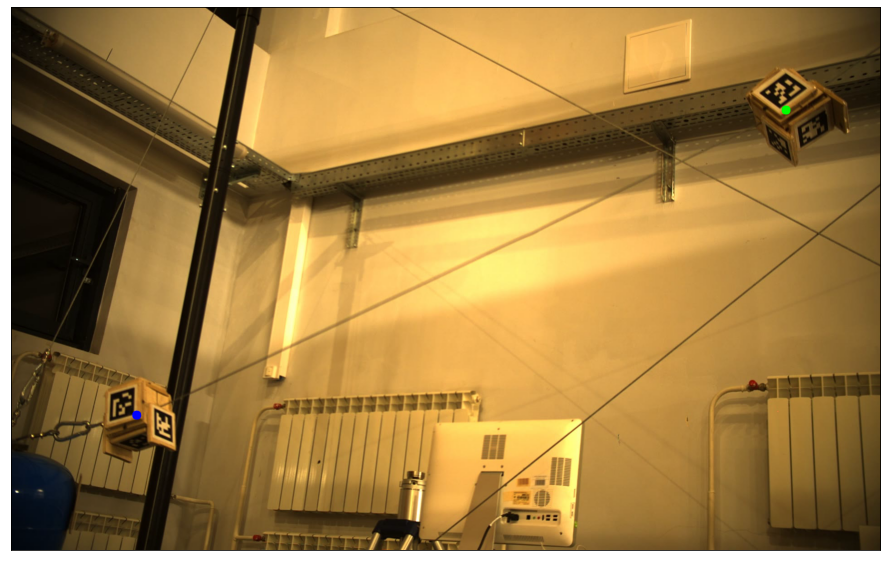

In [14]:
# x, y = get_2d_points(camparam.CameraMatrix, tune_tvector(mmap_low_p, True), mmap_low_p.getRvec())
# x2, y2 = get_2d_points(camparam.CameraMatrix, tune_tvector(mmap_high_p, False), mmap_high_p.getRvec())

x, y = get_2d_from_3d(get_center_box_pos(mmap_low_p, lower_box_loc), camparam.CameraMatrix)
x2,y2 = get_2d_from_3d(get_center_box_pos(mmap_high_p, upper_box_loc), camparam.CameraMatrix)
img_circles = cv2.circle(frame_copy.copy(),(x,y), 10, [255,0,0], cv2.FILLED)
img_circles = cv2.circle(img_circles, (x2,y2), 10, [0,255,0], cv2.FILLED)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_circles, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

[-0.06712168 -0.00887031  3.6891166 ]
[-0.03356084 -0.00443515  1.8445583 ]
(956, 583)


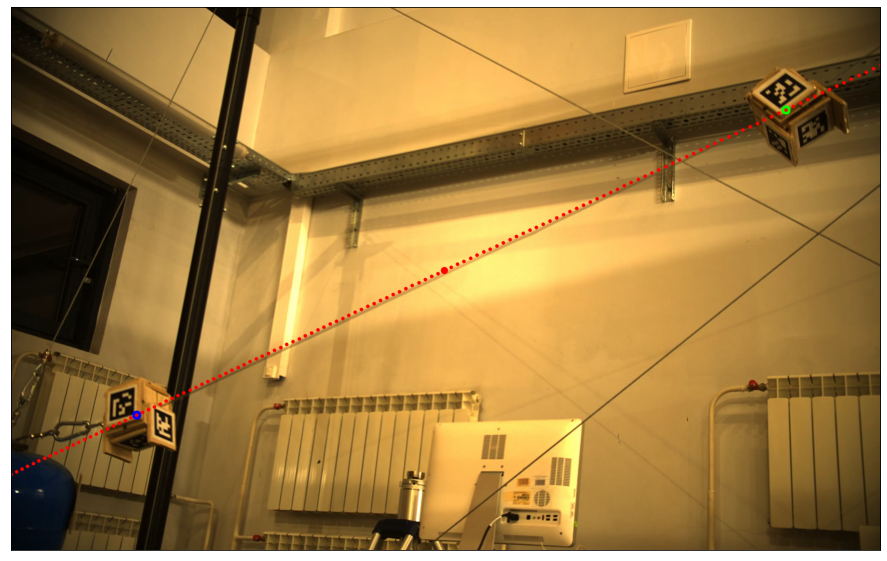

In [15]:
# We can find 3D equation of the line with
# (x,y,z) = B+t*(A-B)
# The middle of the line will be when t=0.5, e.g. 0.5B+0.5A
A = get_center_box_pos(mmap_low_p, lower_box_loc)
B = get_center_box_pos(mmap_high_p, upper_box_loc)
print(A+B)
mp = A*0.5+0.5*B
print(mp)
img_circles = cv2.circle(img_circles, get_2d_from_3d(mp, camparam.CameraMatrix), 8, [0,0,255], cv2.FILLED)
print(get_2d_from_3d(mp, camparam.CameraMatrix))
f = lambda t: B+t*(A-B)
for i in np.arange(-10, 100, step=0.01):
    res = f(i)
    img_circles = cv2.circle(img_circles, get_2d_from_3d(res, camparam.CameraMatrix), 4, [0,0,255], cv2.FILLED)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_circles, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

In [17]:
items = 10

diff_x = int((x2-x)/items)
diff_y = int((y2-y)/items)
diff_x, diff_y

(143, -67)

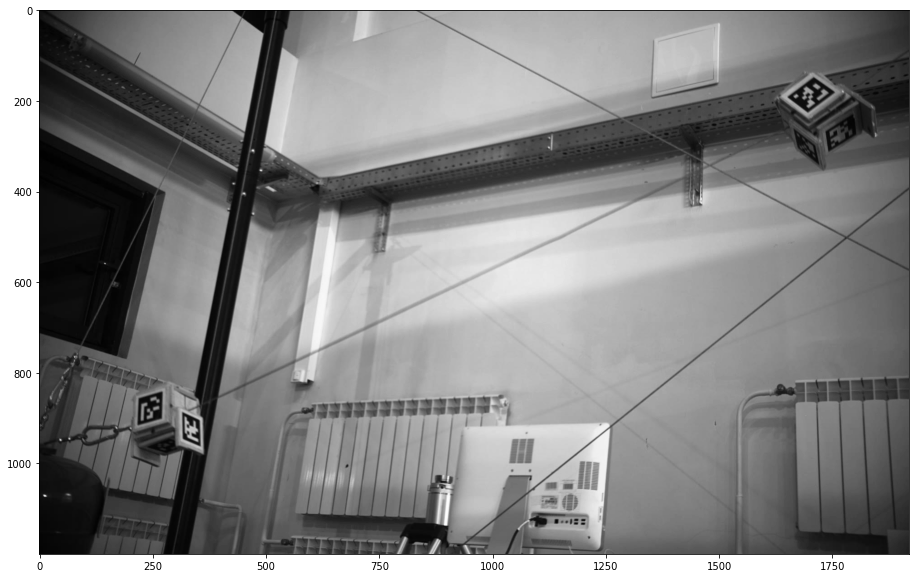

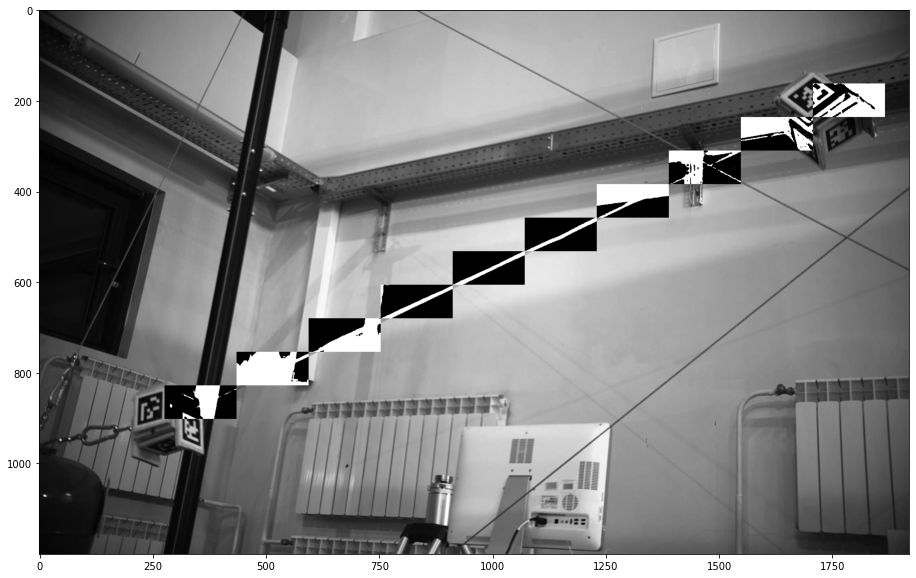

In [17]:
grayed = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(20,10))
plt.imshow(grayed, cmap='gray')
plt.show()

items = 10

diff_x = int((x2-x)/(items-1))
diff_y = int((y2-y)/(items-1))

init_x, init_y = x, y
for i in range(items):
    cropped = grayed[min(init_y,init_y+diff_y):max(init_y,init_y+diff_y), init_x:init_x+diff_x]
    ret2,th2 = cv2.threshold(cropped,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    grayed[min(init_y,init_y+diff_y):max(init_y,init_y+diff_y), init_x:init_x+diff_x] = th2
    
    init_x += diff_x
    init_y += diff_y
    
plt.figure(figsize=(20,10))
plt.imshow(grayed, cmap='gray')
plt.show()

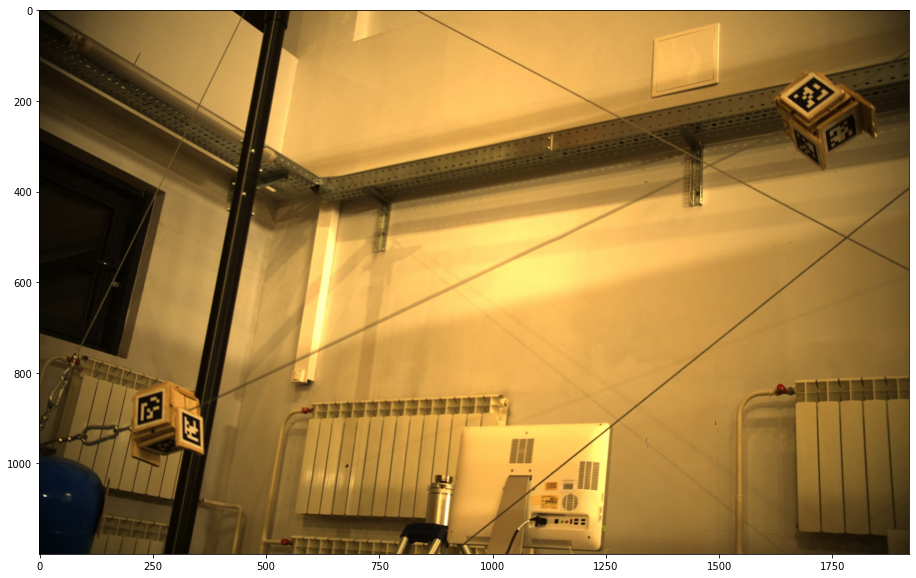

[0, 0] [0, 0]


NameError: name 'cropped_with_line' is not defined

<Figure size 1440x720 with 0 Axes>

In [19]:
# Take the middle of the face markers for lower and upper box
lower_marker = None
upper_marker = None
for marker in markers:
    if marker.id == 24:
        upper_marker = marker
    if marker.id == 7:
        lower_marker = marker
        
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

# We will cut other parts of the image besides those boxes
# min_h, max_h, min_w, max_w = get_heights_width_markers(lower_marker, upper_marker)
min_h, max_h, min_w, max_w = int(B[0]), int(A[0]), int(A[1]), int(B[1]) 

print([min_h, max_h], [min_w, max_w])

# Crop the image, draw a line from the centers of both boxes
cropped = frame[min_w:max_w, min_h:max_h]

#line_p1 = (max(x-min_h,0), max(y-min_w,0))
#line_p2 = (max(x2-min_h,0), max(y2-min_w,0))
#cropped_with_line = cv2.line(cropped.copy(),
#                             line_p1,
#                             line_p2,
#                             [0,0,255], 1)

# middle_point = int((line_p1[1]+line_p2[1])/2), int((line_p2[0]+line_p1[0])/2)
# cropped_with_line = cv2.circle(cropped_with_line, middle_point[::-1], 6, [255,0,0], cv2.FILLED)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(cropped_with_line, cv2.COLOR_BGR2RGB))
# plt.xticks([]), plt.yticks([])
plt.show()

img_converted = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img_converted)
plt.xticks([]), plt.yticks([])
plt.show()

## Locating the wire

In [18]:
grayed = search_for_line(cropped)
plt.figure(figsize=(20,10))
plt.imshow(grayed, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

error: OpenCV(4.4.0) /tmp/pip-req-build-b_zf9wbm/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


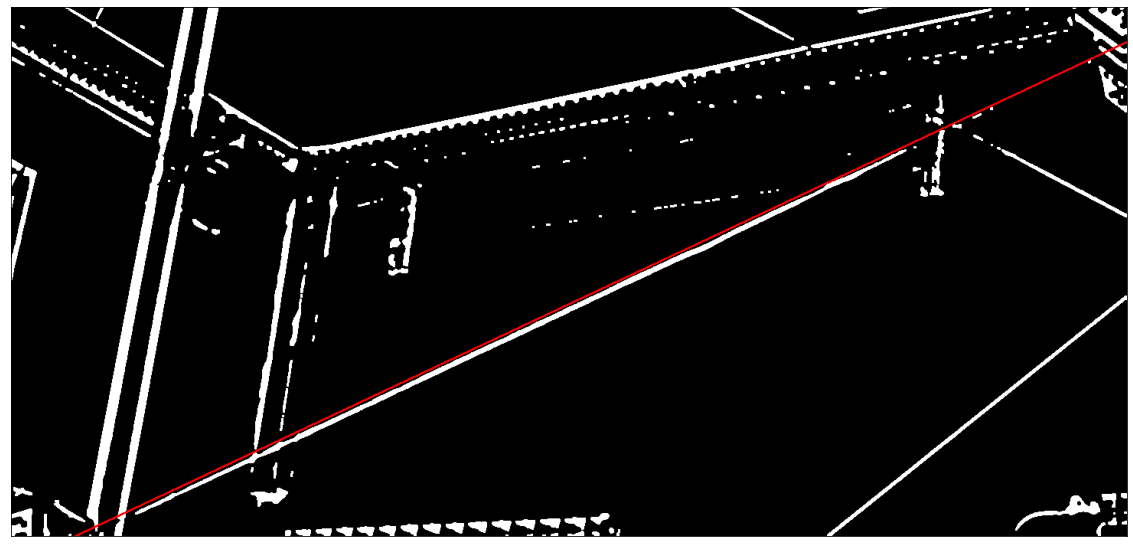

In [21]:
# Red wire represents the perfect location of the cable
grayed_with_line = cv2.cvtColor(grayed, cv2.COLOR_GRAY2RGB)
grayed_with_line = cv2.line(grayed_with_line,
                             line_p1,
                             line_p2,
                             [255,0,0], 2)
plt.figure(figsize=(20,10))
plt.imshow(grayed_with_line)
plt.xticks([]), plt.yticks([])
plt.show()

In [22]:
rays = []
middle_point = int((line_p1[1]+line_p2[1])/2), int((line_p2[0]+line_p1[0])/2) # Middle point of the red line
current_ray = Ray()

# Send a ray down to the bottom of the picture and locate any white pixels in a row
while middle_point[0] != grayed.shape[0]:
    # If white pixel found - add it to the current ray
    if np.all(grayed[middle_point] == [255,255,255]):
        current_ray.add_point(middle_point)
    # else, create a new one if previous one size wasn't 0
    elif current_ray.width != 0:
        rays.append(current_ray)
        current_ray = Ray()
    # Proceed with the iteration
    middle_point = (middle_point[0]+1, middle_point[1]) 

## The distance between our cable and the perfect one

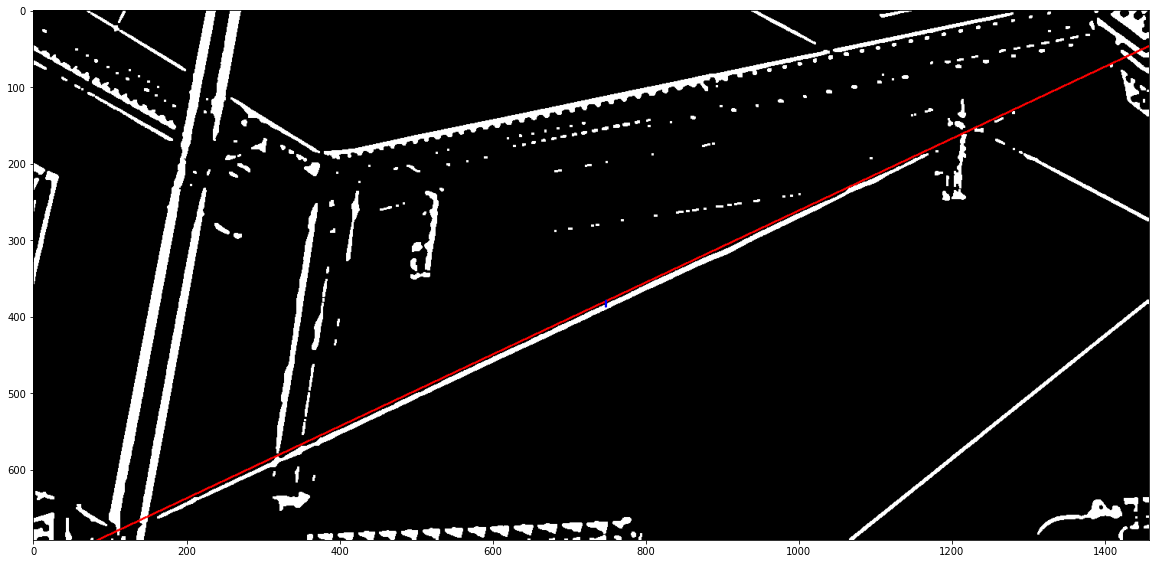

The difference is ~8 pixels to the middle of the cable
Or ~5 pixels from the beginning of the cable


In [77]:
start = int((line_p2[0]+line_p1[0])/2), int((line_p1[1]+line_p2[1])/2)
end = rays[0].get_middle()
grayed_with_two_lines = cv2.line(grayed_with_line.copy(), start, end, [0,0,255], 2)

plt.figure(figsize=(20,10))
plt.imshow(grayed_with_two_lines)
# plt.xticks([]), plt.yticks([])
plt.show()
print(f"The difference is ~{end[1] - start[1]} pixels to the middle of the cable")
print(f"Or ~{rays[0].starting_pos[0]-start[1]} pixels from the beginning of the cable")

In [ ]:
lp = mp
while not get_2d_from_3d(lp, camparam.CameraMatrix) == end:
    lp[1] = lp[1] - 0.001

dst = np.linalg.norm(mp-lp)

print(f"The sagging is {dst} m")


In [169]:
def get_middle_y(img, x, y):
    dynamic_y = y
    while img[dynamic_y, x] == 255:
        dynamic_y +=1
    height_below = dynamic_y - y
        
    dynamic_y = y
    while img[dynamic_y, x] == 255:
        dynamic_y -=1
    height_above = y - dynamic_y
    
    mean = int((height_below+height_above)/2)
    
    return y - (height_above-mean)
    
def find_points(img, middle):
    x, y = middle
    h, w = img.shape
    xs = [x]
    ys = [y]
    
    tmp_x = x+1
    tmp_y = y
    while w > tmp_x and h > tmp_y and img[tmp_y, tmp_x] == 255:
        tmp_y = get_middle_y(img, tmp_x, tmp_y)
        xs.append(tmp_x)
        ys.append(tmp_y)
        tmp_x +=1
    
    tmp_x = x-1
    tmp_y = y
    while w > tmp_x and h > tmp_y and img[tmp_y, tmp_x] == 255:
        tmp_y = get_middle_y(img, tmp_x, tmp_y)
        xs.append(tmp_x)
        ys.append(tmp_y)
        tmp_x -=1
    
    return xs, ys

xs, ys = find_points(grayed, rays[0].get_middle())


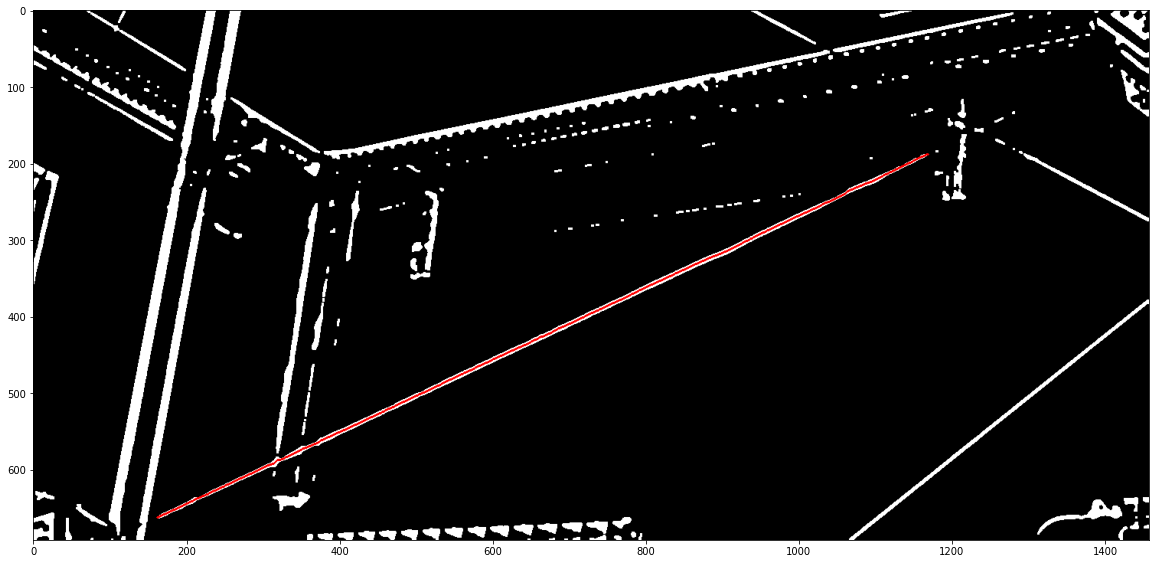

In [177]:
cool = cv2.cvtColor(grayed.copy(), cv2.COLOR_GRAY2RGB)
for x, y in zip(xs, ys):
    cool = cv2.circle(cool, (x,y), 1, [255,0,0], cv2.FILLED)

plt.figure(figsize=(20,10))
plt.imshow(cool)
plt.show()

In [178]:
hm, hm2 = list(zip(*sorted(zip(xs,ys), key=lambda x: x[0])))

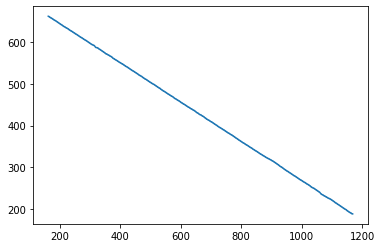

In [213]:
plt.plot(hm, hm2)
plt.show()

## Finding Catenary

Given points on the line we can predict the catenary

In [180]:
import torch

In [264]:
torch.optim.lr_scheduler.ReduceLROnPlateau?

In [269]:
def lsq_catenary(x,a,b,c):
    return a+b*(torch.cosh((x-c)/b)-1)

def lsq_loss(y, y_hat):
    return torch.norm(y-y_hat)
class CatenaryPredictor:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        self.a = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)
        self.b = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)
        self.c = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)
        
        self.optimizer = torch.optim.SGD([self.a, self.b, self.c], lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min',patience=100,factor=0.80)
    
    
    def solve(self, iters=10000):
        for i in range(iters):
            self.optimizer.zero_grad()

            ys = lsq_catenary(self.x, self.a, self.b, self.c)
            loss = lsq_loss(self.y, ys)
            if i % 1000 == 0:
                print(f'Epoch {i}. Loss {loss}')

            loss.backward()
            self.optimizer.step()
            self.scheduler.step(loss)
        return self.a, self.b, self.c, ys

Epoch 0. Loss 13.202040672302246
Epoch 1000. Loss 0.3982942998409271
Epoch 2000. Loss 0.33767029643058777
Epoch 3000. Loss 0.3046669065952301
Epoch 4000. Loss 0.28532570600509644
Epoch 5000. Loss 0.2700786590576172
Epoch 6000. Loss 0.25761526823043823
Epoch 7000. Loss 0.2477252334356308
Epoch 8000. Loss 0.24038834869861603
Epoch 9000. Loss 0.23384009301662445
Fitted arguments are a = -0.023877911269664764, b = 1.6114252805709839, c = -0.38132306933403015


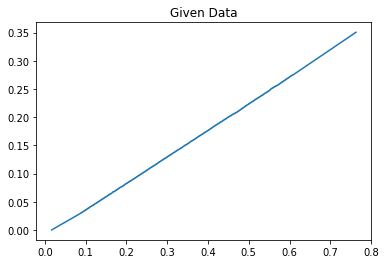

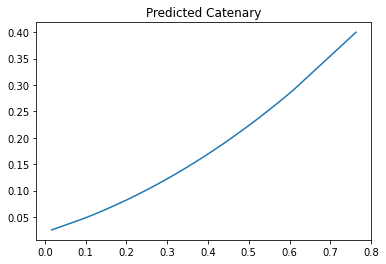

In [270]:
middle_x, middle_y = rays[0].get_middle()
x, y = torch.Tensor([line_p1[0], *hm ,line_p2[0]])/1920, torch.Tensor([line_p1[1], *hm2 ,line_p2[1]])/1920
y = max(y) - y
cat = CatenaryPredictor(x, y)
a, b, c, kek =cat.solve()

print(f'Fitted arguments are a = {a}, b = {b}, c = {c}')
plt.plot(x, y)
# plt.gca().invert_yaxis()
plt.title('Given Data')
plt.show()

y_sample = lsq_catenary(x, a, b, c)
plt.plot(list(x), list(y_sample))
# plt.gca().invert_yaxis()
plt.title('Predicted Catenary')
plt.show()

## Simulation

**Step I. Init**

**Assume**:

1) we know $a$

2) catenary of form $y = f(x) = a \cosh {\frac{x+c_1}{a}}+c_2$. Assume $c_1=1$ and $c_2=0$

Also assume that we know the $x_{1,1}$ and $x_{2,1}$, thus the vectors are 

$x_1=[x_{1,1}\ f(x_{1,1})]$

$x_2=[x_{2,1}\ f(x_{2,1})]$

Now, we know camera parameters $C_{3\times3}$ and assume that $Q_c = I_{3\times3}$ and $t_c = [0\ 0\ 100]$

We now project $\vec{x} \rightarrow \vec{u}$ with $\vec{u}_1 = C[Q_c | t_c]\vec{x}_1$

We then add some noise from $N(0, 1)$ to the $\vec{u}$ and get $\tilde{u}$

**Step II. Fit**

We have as an input $\tilde{u}_1$, $\tilde{u}_2$
And get the ouput as $[a,\ x_{1,2},\ x_{2,2}]$

We need to minimze M, e.g. $\min M = [\tilde{u}-g(a,x_{1,2},x_{2,2})]$

In [ ]:
def catenary(x, a):
    return a*torch.cosh((x+1)/a) # Assume the form of catenary

In [ ]:
def to_image(vector_x, camera):
    # Projects 3D vectors to 2D image coordinates given camera configuration
    Q = torch.Tensor(np.identity(3)) # Assume Q is identity
    t = torch.Tensor([0, 0, 100]).unsqueeze(1) # Assume t is [0 0 100]
    
    concatenated = torch.cat((Q, t), 1) # Get Q|t
    img = camera @ concatenated @ vector_x # C[Q|T]x
    img = img/img[-1] # divide by z to get coordinates
    return img

In [ ]:
def add_noise(*vector_u):
     # Adds noise from N(0, 1) to all vectors in the input
    return list(map(lambda x: x+torch.normal(0,1,(2,)), vector_u))

In [ ]:
def calculate_error(u, u_hat, error_func=lambda x: torch.norm(x, 2)):
    # Calculates error function, given by the user (second norm by default)
    return error_func(u - u_hat)

In [ ]:
def calculate_step(a, x_1, x_2, camera_matrix, requires_grad=False):
    # One step of the optimization
    y_1 = catenary(x_1, a) # Calculate y1 and y2 values using assumed form of the catenary
    y_2 = catenary(x_2, a)
    
    # Stack values of xs and ys to get the 3D vector (z=0 as they are in the same plane)
    zero, one = torch.tensor(0, dtype=torch.float32), torch.tensor(1, dtype=torch.float32)
    vector_x1 = torch.stack((x_1, y_1, zero, one))
    vector_x2 = torch.stack((x_2, y_2, zero, one))
    
    # Project to the image space
    u1 = to_image(vector_x1, camera_matrix)[:2]
    u2 = to_image(vector_x2, camera_matrix)[:2]
    
    return u1, u2

In [ ]:
# Initial values ofr a, x1 and x2
init_a = torch.tensor(1.5, dtype=torch.float32)
init_x1 = torch.tensor(0, dtype=torch.float32)
init_x2 = torch.tensor(2, dtype=torch.float32)

camera_matrix = torch.Tensor(camparam.CameraMatrix)

# The tilde u1, u2 that we would like to approximate
perfect_u1, perfect_u2 = add_noise(*calculate_step(init_a, init_x1, init_x2, camera_matrix))

In [ ]:
# Trainables a, x1 and x2
a = torch.tensor(1, dtype=torch.float32, requires_grad=True)
x_1 = torch.tensor(0, dtype=torch.float32, requires_grad=True)
x_2 = torch.tensor(0, dtype=torch.float32, requires_grad=True)

# Init optimizer and learning rate scheduler
optimizer = torch.optim.SGD([a, x_1, x_2], lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.99)

# Going through epochs we will try to minimize the error of our predicted u against tilde u
for i in range(10000):
    optimizer.zero_grad()
    
    # Get current u's
    new_u1, new_u2 = calculate_step(a, x_1, x_2, camera_matrix, True)
    
    # Calculate loss
    loss = (calculate_error(perfect_u1, new_u1) + calculate_error(perfect_u2, new_u2))/2
    if i % 1000 == 0:
        print(f'Epoch {i}. Loss {loss}')

    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
print(f'Fitted: a={a.item()}, x_1 = {x_1.item()}, x_2 = {x_2.item()}')
print(f'Real values were: a={init_a.item()}, x_1 = {init_x1.item()}, x_2 = {init_x2.item()}')

print(f'Perfect u1 = {perfect_u1.numpy()}, u2 = {perfect_u2.numpy()}')
print(f'Ours u1 = {new_u1.detach().numpy()}, u2 = {new_u2.detach().numpy()}')